In [1]:
import sys
sys.path.append('../../')

import json
import pandas as pd
import numpy as np
from core.database import get_client
from sklearn.preprocessing import Imputer
from utils import centered_subways, get_nearest_undergroud, encode_with_OneHotEncoder_and_delete_column, encode_with_LabelEncoder, perform_coding_and_delete_column

In [2]:
client = get_client()
db = client.underpriced
flats = list(db.unprocessedFlats.find())

In [3]:
# df = pd.read_json("/home/alena/Documents/underpriced/aggregation_module/flats.json", orient='values')

In [4]:
df = pd.DataFrame.from_records(flats)

In [5]:
df.set_index(df['_id'], inplace=True)
df = df.drop('_id', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16042 entries, 165528286 to 167544860
Data columns (total 28 columns):
address                    16042 non-null object
apartment_status           92 non-null object
area                       16041 non-null object
balcony                    16041 non-null object
ceiling_height             6546 non-null object
combined_bathroom_count    7075 non-null object
construction_year          10742 non-null object
description                16042 non-null object
district                   16042 non-null object
elevator                   10592 non-null object
floor                      16038 non-null object
house_type                 12153 non-null object
images                     16042 non-null object
kitchen_area               16041 non-null object
living_area                16041 non-null object
parking                    5503 non-null object
price                      16042 non-null object
processed                  547 non-null object
ramp      

In [7]:
df.rooms.value_counts()

2                                                    6477
3                                                    4370
1                                                    4212
4                                                     762
5                                                     141
студия на длительный срок (от года)                    56
многокомн. кв. на длительный срок (от года)            15
свободная планировка на длительный срок (от года)       3
студия на несколько месяцев (меньше года)               3
многокомн. кв. посуточно                                1
Name: rooms, dtype: int64

In [8]:
df.shape

(16042, 28)

In [9]:
df.shape

(16042, 28)

In [10]:
df = df.drop(['apartment_status', 'address', 'description', 'images', 'district', 'room_area', 'url', 'view', 'processed'], axis=1)

In [11]:
# df = df.drop(['apartment_status', 'address', 'description', 'images', 'district', 'room_area', 'url', 'view'], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16042 entries, 165528286 to 167544860
Data columns (total 19 columns):
area                       16041 non-null object
balcony                    16041 non-null object
ceiling_height             6546 non-null object
combined_bathroom_count    7075 non-null object
construction_year          10742 non-null object
elevator                   10592 non-null object
floor                      16038 non-null object
house_type                 12153 non-null object
kitchen_area               16041 non-null object
living_area                16041 non-null object
parking                    5503 non-null object
price                      16042 non-null object
ramp                       1645 non-null object
repair                     14663 non-null object
room_type                  5121 non-null object
rooms                      16040 non-null object
sleeping_place_count       27 non-null object
split_bathroom_count       6873 non-null object
underground

In [13]:
df.shape

(16042, 19)

In [14]:
# nulls more than a half
df = df.drop(['room_type', 'ceiling_height', 'parking', 'ramp', 'sleeping_place_count', 'split_bathroom_count', 'elevator'], axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16042 entries, 165528286 to 167544860
Data columns (total 12 columns):
area                       16041 non-null object
balcony                    16041 non-null object
combined_bathroom_count    7075 non-null object
construction_year          10742 non-null object
floor                      16038 non-null object
house_type                 12153 non-null object
kitchen_area               16041 non-null object
living_area                16041 non-null object
price                      16042 non-null object
repair                     14663 non-null object
rooms                      16040 non-null object
underground                16042 non-null object
dtypes: object(12)
memory usage: 1.6+ MB


In [16]:
df = df.dropna(axis=0, how='any', subset=['area'])
df['area'] = df['area'].map(lambda x: float(x.replace(',', '.')) if ',' in x else float(x))

In [17]:
df['has_balcony'] = df['balcony'].map(lambda x: 1 if x.find(u'есть балкон') != -1 else 0)
df['has_loggia'] = df['balcony'].map(lambda x: 1 if x.find(u'есть лоджия') != -1 else 0)
df = df.drop('balcony', axis=1)

In [18]:
imputer = Imputer(missing_values=np.nan, strategy="median", axis=0)
df['combined_bathroom_count'] = imputer.fit_transform(df['combined_bathroom_count'].values.reshape(-1, 1))
df['combined_bathroom_count'] = df['combined_bathroom_count'].map(lambda x: int(x))

In [19]:
imputer = Imputer(missing_values=np.nan, strategy="median", axis=0)
df['construction_year'] = imputer.fit_transform(df['construction_year'].values.reshape(-1, 1))
df['construction_year'] = df['construction_year'].map(lambda x: int(x))

In [20]:
df = df.dropna(axis=0, how='any', subset=['floor'])

In [21]:
df['curr_floor'] = df['floor'].map(lambda x: int(str(x).split(' / ')[0]))
df['total_floor'] = df['floor'].map(lambda x: int(str(x).split(' / ')[1]))
df = df.drop('floor', axis=1)

In [22]:
df = df.dropna(axis=0, how='any', subset=['house_type'])

In [23]:
df['kitchen_area'] = df['kitchen_area'].map(lambda x: x.replace(',', '.') if ',' in x else x)
df.loc[df.kitchen_area == '–', 'kitchen_area'] = np.nan
df['kitchen_area'] = df['kitchen_area'].map(lambda x: float(x) if x is not None else x)
imputer = Imputer(missing_values=np.nan, strategy="mean", axis=0)
df['kitchen_area'] = imputer.fit_transform(df['kitchen_area'].values.reshape(-1, 1)) 

In [24]:
df['living_area'] = df['living_area'].map(lambda x: x.replace(',', '.') if ',' in x else x)
df.loc[df.living_area == '–', 'living_area'] = np.nan
df['living_area'] = df['living_area'].map(lambda x: float(x) if x is not None else x)
imputer = Imputer(missing_values=np.nan, strategy="mean", axis=0)
df['living_area'] = imputer.fit_transform(df['living_area'].values.reshape(-1, 1))

In [25]:
df.price.isnull().sum()

0

In [26]:
df = df.dropna(axis=0, how='any', subset=['repair'])

In [27]:
df['rooms'] = df['rooms'].map(lambda x: -1 if type(x) == str and x.find(u'студия') != -1 else x)
df['rooms'] = df['rooms'].map(lambda x: 6 if type(x) == str and x.find(u'многокомн') != -1 else x)
df['rooms'] = df['rooms'].map(lambda x: np.nan if type(x) == str and x == 'свободная планировка на длительный срок (от года)' else x)
df = df.dropna(axis=0, how='any', subset=['rooms'])
df['rooms'] = df['rooms'].map(lambda x: int(x))

In [28]:
df['underground'] = df['underground'].map(lambda x: np.nan if x == {} else x) 
df = df.dropna(axis=0, how='any', subset=['underground'])
df['underground_name'] = df['underground'].map(lambda item: str(get_nearest_undergroud(item)).lower())
df['is_center'] = df['underground_name'].map(lambda item: 1 if item in centered_subways else 0)

In [29]:
def get_way(item):
    if 'пешком' in item[get_nearest_undergroud(item)]:
        return -1
    if 'машине' in item[get_nearest_undergroud(item)]:
        return 1
    return None

In [30]:
df['underground_way'] = df.underground.map(lambda x: get_way(x))

In [31]:
df['underground_time'] = df.underground.map(lambda x: int(x[get_nearest_undergroud(x)].split(' ')[0]))

In [32]:
# nulls more than a half
df = df.drop(['underground'], axis=1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11592 entries, 165528286 to 167544860
Data columns (total 17 columns):
area                       11592 non-null float64
combined_bathroom_count    11592 non-null int64
construction_year          11592 non-null int64
house_type                 11592 non-null object
kitchen_area               11592 non-null float64
living_area                11592 non-null float64
price                      11592 non-null object
repair                     11592 non-null object
rooms                      11592 non-null int64
has_balcony                11592 non-null int64
has_loggia                 11592 non-null int64
curr_floor                 11592 non-null int64
total_floor                11592 non-null int64
underground_name           11592 non-null object
is_center                  11592 non-null int64
underground_way            11592 non-null int64
underground_time           11592 non-null int64
dtypes: float64(3), int64(10), object(4)
memory usage: 1.6

In [34]:
average_data = {}
for col in df.columns:
    if df[col].dtypes != object:
        average_data[col] = df[col].mean()

with open('average_data.json', 'w') as outfile:
    json.dump(average_data, outfile)

In [35]:
res = df[df.price == 90000]

In [36]:
df.repair.isnull().sum()

0

In [37]:
df, metro_le_encoder = encode_with_OneHotEncoder_and_delete_column(df,'underground_name')
df, house_type_le_encoder = encode_with_OneHotEncoder_and_delete_column(df,'house_type')
df, repair_le_encoder = encode_with_OneHotEncoder_and_delete_column(df,'repair')

In [38]:
df.shape

(11592, 231)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11592 entries, 165528286 to 167544860
Columns: 231 entries, area to repair=отсутствует
dtypes: float64(220), int64(10), object(1)
memory usage: 20.5+ MB


In [40]:
df.price = df.price.map(lambda item: int(item['rub_price']) if 'rub_price' in item else np.nan)

In [41]:
df = df[df.price <= 200000]

In [42]:
df = df[df.price >= 15000]

In [43]:
df = df.dropna(axis=0, how='any', subset=['price'])

In [51]:
df = df.drop(df.query('20000 < price < 60000').sample(frac=.4).index)

In [58]:
df = df.drop(df.query('price == 25000').sample(frac=.5).index)

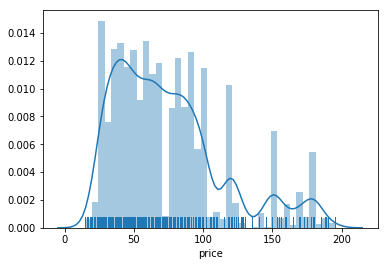

In [66]:
%matplotlib inline
import seaborn as sns

# Распределение квартир по цене:
sns.distplot(df.price / 1000);

In [60]:
with open('features.json', 'w') as outfile:
    all_columns = {}
    all_columns['features'] = df.columns.tolist()
    json.dump(all_columns, outfile)

In [61]:
df.shape

(7241, 231)

In [62]:
df.to_csv('flats_data.csv')

In [67]:
res = df[df.price == 90000]

In [70]:
res.head()

,area,combined_bathroom_count,construction_year,kitchen_area,living_area,price,rooms,has_balcony,has_loggia,curr_floor,...,house_type=кирпично-монолитный,house_type=кирпичный,house_type=монолитный,house_type=панельный,house_type=сталинский,house_type=старый фонд,repair=дизайнерский,repair=евроремонт,repair=косметический,repair=отсутствует
_id,,,,,,,,,,,,,,,,,,,,,
165680395,97.0,2,2014,10.0,67.0,90000,3,1,0,9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
166760698,54.0,1,1971,6.0,35.0,90000,2,1,0,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
165680393,97.0,2,2014,10.0,67.0,90000,3,1,0,9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
166760699,54.0,1,1971,6.0,35.0,90000,2,1,0,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
163925414,100.0,1,1976,10.0,68.0,90000,3,0,0,10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
